In [1]:
%matplotlib inline

In [4]:
from hashlib import md5, sha256, sha512
from time import time
from string import printable
from itertools import product, count
from csv import writer
import pandas as pd
import matplotlib.pyplot as plt

# The importance of keeping passwords hashed and "salted" in the database

Any computer system that requires password authentication must contain a database of passwords, either obfuscated or in plaintext, and various methods of password storage exist. Because the tables are vulnerable to theft, storing the plaintext password is dangerous. Most databases, therefore, store a cryptographic hash of a user's password in the database. In such a system, no one – including the authentication system – can determine what a user's password is by merely looking at the value stored in the database. Instead, when a user enters a password for authentication, the system computes the hash value for the provided password, and that hash value is compared to the stored hash for that user. Authentication is successful if the two hashes match.

Below, I will implement simple brute force algorithm that will try to break the hashed password from the user. I will examine how much time is needed to crack the password depending on word legth and cryptography functions that was used.


### Hash function and their usage 

Hash function is any function that can be used to map data of arbitrary size to fixed-size values. The values returned by a hash function are called hash values, hash codes, digests, or simply hashes. The values are used to index a fixed-size table called a hash table. Use of a hash function to index a hash table is called hashing or scatter storage addressing.

### Criptographic hash functions

A cryptographic hash function (CHF) is a hash function that is suitable for use in cryptography. It is a mathematical algorithm that maps data of arbitrary size (often called the "message") to a bit string of a fixed size (the "hash value", "hash", or "message digest") and is a one-way function, that is, a function which is practically infeasible to invert. Ideally, the only way to find a message that produces a given hash is to attempt a brute-force search of possible inputs to see if they produce a match, or use a rainbow table of matched hashes. Cryptographic hash functions are a basic tool of modern cryptography.

The ideal cryptographic hash function has the following main properties:

1. It is deterministic, meaning that the same message always results in the same hash
2. It is quick to compute the hash value for any given message
2. It is infeasible to generate a message that yields a given hash value
4. It is infeasible to find two different messages with the same hash value
a small change to a message should change the hash value so extensively that the new hash value appears uncorrelated with the old hash value (avalanche effect).

### Cryptographic hash functions that will be used in this paper

**MD5** - The fastest and shortest generated hash (**16 bytes**). The probability of just two hashes accidentally colliding is approximately: $1.47*10^{-29}$.

**SHA256** - Is generally 20% slower than md5, the generated hash is a bit longer than MD5 (**20 bytes**). The probability of just two hashes accidentally colliding is approximately: $1*10^{-45}$

**SHA512** - The slowest, usually 60% slower than md5, and the longest generated hash (**32 bytes**). The probability of just two hashes accidentally colliding is approximately: $4.3*10^{-60}$.

### Collision attacks

In cryptography, a collision attack on a cryptographic hash tries to find two inputs producing the same hash value, i.e. a hash collision. This is in contrast to a preimage attack where a specific target hash value is specified.

There are roughly two types of collision attacks:

#### Collision attack
Find two different messages m1 and m2 such that hash(m1) = hash(m2).
More generally:

#### Chosen-prefix collision attack
Given two different prefixes p1 and p2, find two appendages m1 and m2 such that hash(p1 ∥ m1) = hash(p2 ∥ m2), where ∥ denotes the concatenation operation.

More efficient attacks are possible by employing cryptanalysis to specific hash functions. When a collision attack is discovered and is found to be faster than a birthday attack, a hash function is often denounced as "broken". The NIST hash function competition was largely induced by published collision attacks against two very commonly used hash functions, MD5 and SHA-1. The collision attacks against MD5 have improved so much that, as of 2007, it takes just a few seconds on a regular computer. Hash collisions created this way are usually constant length and largely unstructured, so cannot directly be applied to attack widespread document formats or protocols

## Web site attacks

The simplest way to crack a hash is to try to guess the password, hashing each guess, and checking if the guess's hash equals the hash being cracked. If the hashes are equal, the guess is the password. The two most common ways of guessing passwords are **dictionary attacks** and **brute-force attacks**.

A **dictionary attack** uses a file containing words, phrases, common passwords, and other strings that are likely to be used as a password. Each word in the file is hashed, and its hash is compared to the password hash. If they match, that word is the password. These dictionary files are constructed by extracting words from large bodies of text, and even from real databases of passwords. Further processing is often applied to dictionary files, such as replacing words with their "leet speak" equivalents ("hello" becomes "h3110"), to make them more effective.

A **brute-force** attack tries every possible combination of characters up to a given length. These attacks are very computationally expensive, and are usually the least efficient in terms of hashes cracked per processor time, but they will always eventually find the password. Passwords should be long enough that searching through all possible character strings to find it will take too long to be worthwhile.

There is no way to prevent dictionary attacks or brute force attacks. They can be made less effective, but there isn't a way to prevent them altogether. If your password hashing system is secure, the only way to crack the hashes will be to run a dictionary or brute-force attack on each hash.

**Lookup tables** are an extremely effective method for cracking many hashes of the same type very quickly. The general idea is to pre-compute the hashes of the passwords in a password dictionary and store them, and their corresponding password, in a lookup table data structure. A good implementation of a lookup table can process hundreds of hash lookups per second, even when they contain many billions of hashes.

**Reverse Lookup tables** attack allows an attacker to apply a dictionary or brute-force attack to many hashes at the same time, without having to pre-compute a lookup table.
First, the attacker creates a lookup table that maps each password hash from the compromised user account database to a list of users who had that hash. The attacker then hashes each password guess and uses the lookup table to get a list of users whose password was the attacker's guess. This attack is especially effective because it is common for many users to have the same password.

**Rainbow tables** are a time-memory trade-off technique. They are like lookup tables, except that they sacrifice hash cracking speed to make the lookup tables smaller. Because they are smaller, the solutions to more hashes can be stored in the same amount of space, making them more effective. Rainbow tables that can crack any md5 hash of a password up to 8 characters long exist.

### Methods for generating random strings, compare hash codes and write final results to csv file

In [35]:
def passwords(encoding):
    chars = [c.encode(encoding) for c in printable]
    for length in count(start=1):
        for pwd in product(chars, repeat=length):
            yield b''.join(pwd)
            
            
def crack(hash_function, search_hash, encoding):
    for pwd in passwords(encoding):
        if hash_function(pwd).digest() == search_hash:
            return pwd.decode(encoding)
        
        
def append_list_to_csv(file_name, list_of_elem):
    with open(file_name, 'a+', newline='') as write_obj:
        csv_writer = writer(write_obj)
        csv_writer.writerow(list_of_elem)
        
        
def calculate_cracking_time(pass_to_crack, encoding, result_file):
    hash_funcs = (md5, sha256, sha512)
    hash_funcs_names = ('MD5', 'SHA256', 'SHA512')
    
    for i in range(3):
        hashed_pass = hash_funcs[i](pass_to_crack.encode(encoding)).digest()
        
        start = time()
        cracked = crack(hash_funcs[i], hashed_pass, encoding)
        end = time()
        duration = round(end - start, 6)
        
        print(f"Password cracked with {hash_funcs_names[i]}: {cracked} for {duration} seconds")
        append_list_to_csv(result_file,[hash_funcs_names[i], pass_to_crack, cracked, duration])  

    

### Initial data and passwords hash generation

In [ ]:
encoding = 'ascii'  # utf-8 for unicode support
password = '1234567' # type password that is about to broke

csv_file = 'data.csv'
calculate_cracking_time(password, encoding, csv_file) #store result in csv file


### Method for processing stored data

In [37]:
def average_durations_per_hash_method(file_nale):
    data = pd.read_csv("data.csv")

    data_by_method = {}

    for ind, row in data.iterrows():
        cryp_func = str(row["method"])
        pass_length = len(row["pass"])
        duration = row["time"]
        
        if cryp_func not in data_by_method:
            data_by_method[cryp_func] = {}
        if pass_length not in data_by_method[cryp_func]:
            data_by_method[cryp_func][pass_length] = []    

        data_by_method[cryp_func][pass_length].append(duration)

    avg_dur_by_method = {}

    for method, val in data_by_method.items():
        for length, times in val.items():
            if method not in avg_dur_by_method:
               avg_dur_by_method[method] = {}
            if length not in avg_dur_by_method[method]:        
                avg_dur_by_method[method][length] = sum(times)/len(times)
    
    return avg_dur_by_method

### Reding stored samples and processing

In [40]:
file_to_read = "data.csv"
averageg_dur_by_method = average_durations_per_hash_method(file_to_read)

### Graphical result

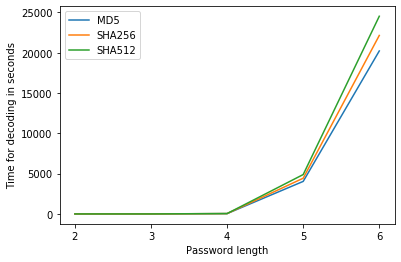

In [39]:
plt.plot(list(averageg_dur_by_method["MD5"].keys()), list(averageg_dur_by_method["MD5"].values()),  label = "MD5")
plt.plot(list(averageg_dur_by_method["SHA256"].keys()), list(averageg_dur_by_method["SHA256"].values()), label = "SHA256")
plt.plot(list(averageg_dur_by_method["SHA512"].keys()), list(averageg_dur_by_method["SHA512"].values()), label = "SHA512" )

plt.xlabel("Password length")
plt.ylabel("Time for decoding in seconds")

plt.legend()
plt.xticks(range(2,7), range(2,7))
plt.show()

### Tabular result

<img src="DecodingTimeTable.PNG">


### Hardware setup

All passwordes were cracked with regular desktop - Intel Core i5 CPU 3.30Ghz, 16 Gb RAM, 30% of CPU was used. With appropriate video card those calculation can be enchanced a lot. In other words, passwords have to be very long in order to increase drastically cracking time, but because long passwords are hard to remember and use **salting** is a must

## Salting the password

A technique called **salting**, which makes it impossible to use lookup tables and rainbow tables to crack a hash.

Lookup tables and rainbow tables only work because each password is hashed the exact same way. If two users have the same password, they'll have the same password hashes. We can prevent these attacks by randomizing each hash, so that when the same password is hashed twice, the hashes are not the same.

We can randomize the hashes by appending or prepending a random string, called a **salt**, to the password before hashing. As shown in the example above, this makes the same password hash into a completely different string every time. To check if a password is correct, we need the salt, so it is usually stored in the user account database along with the hash, or as part of the hash string itself.

The salt does not need to be secret. Just by randomizing the hashes, lookup tables, reverse lookup tables, and rainbow tables become ineffective. An attacker won't know in advance what the salt will be, so they can't pre-compute a lookup table or rainbow table. If each user's password is hashed with a different salt, the reverse lookup table attack won't work either.

Salt should be generated using a **Cryptographically Secure Pseudo-Random Number Generator (CSPRNG)**. CSPRNGs are very different than ordinary pseudo-random number generators, like the "C" language's rand() function. As the name suggests, CSPRNGs are designed to be cryptographically secure, meaning they provide a high level of randomness and are completely unpredictable. We don't want our salts to be predictable, so we must use a CSPRNG.

The salt needs to be unique per-user per-password. Every time a user creates an account or changes their password, the password should be hashed using a new random salt. Never reuse a salt. The salt also needs to be long, so that there are many possible salts. As a rule of thumb, make your salt is at least as long as the hash function's output. The salt should be stored in the user account table alongside the hash.

## Choosing right cryptographic hash function

As we saw salting is a must but cannot solve the entire problem. Chosing secure and slow algorithm is also a must.

Hash functions like MD5, SHA1, and SHA2 use the Merkle–Damgård construction, which makes them vulnerable to what are known as length extension attacks. This means that given a hash H(X), an attacker can find the value of H(pad(X) + Y), for any other string Y, without knowing X. pad(X) is the padding function used by the hash.

This means that given a hash H(key + message), an attacker can compute H(pad(key + message) + extension), without knowing the key. If the hash was being used as a message authentication code, using the key to prevent an attacker from being able to modify the message and replace it with a different valid hash, the system has failed, since the attacker now has a valid hash of message + extension.

It is not clear how an attacker could use this attack to crack a password hash quicker. However, because of the attack, it is considered bad practice to use a plain hash function for keyed hashing. A clever cryptographer may one day come up with a clever way to use these attacks to make cracking faster, so use **HMAC**.


### References

Wikipedia

https://crackstation.net/hashing-security.htm